In [4]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

ROOT_DIR = Path('..')

# import DataLoader as DataLoader
# reload(DataLoader)

# dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

# Data Preparation

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df_final.DIAGNOSIS = df_final.DIAGNOSIS.fillna('')
max_features = 4848

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df_final.DIAGNOSIS))
df_result = tokenizer.texts_to_sequences(df_final.DIAGNOSIS)
df_result = pad_sequences(df_result, maxlen=25)
df_final['EMB_CODED'] = [x for x in df_result]

In [540]:
# t0_df = pd.read_csv(df_final)
path_t0_df = ROOT_DIR / 'data/output_csv/sequence_t4_v2.csv'  
t0_df = pd.read_csv(path_t0_df)# t0_df
admission_t0 = t0_df[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

X_t0_train, X_t0_test, y_t0_train, y_t0_test = train_test_split(
    admission_t0.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    admission_t0['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=admission_t0['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)
X_t0_train = t0_df.merge(X_t0_train[['SUBJECT_ID', 'HADM_ID']])
y_t0_train = X_t0_train.IS_SEPSIS
X_t0_test = t0_df.merge(X_t0_test[['SUBJECT_ID', 'HADM_ID']])
y_t0_test = X_t0_test.IS_SEPSIS

# # If you want to get the train and test set as dataframes:
train_t0_df = X_t0_train
test_t0_df = X_t0_test

# remove unrelated columns
X_t0_train = X_t0_train.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS'])
X_t0_test = X_t0_test.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS'])

In [487]:
# Feature scaling - Standardisation
scaler = StandardScaler()

X_t0_train = scaler.fit_transform(X_t0_train)
X_t0_test = scaler.transform(X_t0_test)

In [502]:
def ts_to_secs(X, Y, w, s, **options):

    ## We want the Rows of matrices show each Feature and the Columns show time points.
    # X = X.T

    # m = X.shape[0]   # Data Dimension
    # ttp = X.shape[1] # Total Time Points
    m = X.shape[1]   # Data Dimension
    ttp = X.shape[0] # Total Time Points
    # number_of_secs = int(round(((ttp - w)/s)))
    number_of_secs = int(round((ttp/s)))

    ##  Create a 3D matrix for Storing Sections
    # secs_data = np.zeros((number_of_secs , m , w ))
    secs_data = np.zeros((number_of_secs , w , m ))
    # act_secs_labels = np.zeros(number_of_secs)
    act_secs_labels = []
    k=0
    for i in range(0 , ttp-w, s):
        # secs_data[k] = X[:, i:i+w]
        secs_data[k] = X[i:i+w, :]
        # act_secs_labels[k] = y_t0_train.reset_index().iloc[0].IS_SEPSIS.astype(int)
        sub_act = [0, 0]
        true_index = Y[i].astype(int)
        sub_act[true_index] = 1
        act_secs_labels.append(sub_act)
        k = k+1

    secs_data = secs_data[0:k]
    act_secs_labels = np.array(act_secs_labels[0:k])
    return secs_data, act_secs_labels


In [503]:
def data_preparation(w, s):
  ## This Variable Defines the Size of Sliding Window
  ## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor)
  # w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
  ## Here We Choose Step Size for Building Different Snapshots from Time-Series Data
  ## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
  # s = 10
  train_data, act_train = ts_to_secs(X_t0_train, y_t0_train,
                                      w,
                                      s)

  # s = 10
  test_data, act_test = ts_to_secs(X_t0_test, y_t0_test,
                                      w,
                                      s)


  ## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  # train_data = np.expand_dims(train_data,axis=3)
  print("[INFO] -- Shape of Training Sections:", train_data.shape)
  # test_data = np.expand_dims(test_data,axis=3)
  print("[INFO] -- Shape of Test Sections:", test_data.shape)

  return train_data, act_train, test_data, act_test

In [536]:
train_data, act_train, test_data, act_test = data_preparation(w=4, s=4)
act_label = ['NON-SEPSIS', 'SEPSIS']

[INFO] -- Shape of Training Sections: (36931, 4, 32)
[INFO] -- Shape of Test Sections: (9232, 4, 32)


# Model Training

In [482]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import tensorflow as tf
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

def LSTM_model():
    d = 0.25
    model=Sequential()
    model.add(Input(shape=(None, 32)))
    model.add(LSTM(128, return_sequences=True))
    # model.add(LSTM(4,return_sequences=True,input_shape=(32,4)))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(75))
    model.add(Dropout(d))
    model.add(Dense(25))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, None, 128)         82432     
                                                                 
 dropout_52 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_43 (LSTM)              (None, None, 64)          49408     
                                                                 
 dropout_53 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_44 (LSTM)              (None, 75)                42000     
                                                                 
 dropout_54 (Dropout)        (None, 75)                0         
                                                                 
 dense_26 (Dense)            (None, 25)              

In [467]:
def get_class_weights():
  label_counts = y_t0_train.value_counts()
  label_proportions = label_counts / len(y_t0_train)*100
  # Calculate class weights
  class_weights = {0: 1 / (label_proportions[0] / 100), 1: 1 / (label_proportions[1] / 100)}

  # Round the class weights to the desired precision (optional)
  class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}
  return class_weights

get_class_weights()

{0: 1.1207, 1: 9.2841}

In [505]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', save_best_only = True, monitor='mse', mode='min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', patience = 20)
callbacks_list = [early_stop, checkpointer]
m = model.fit(train_data, y_train, 
              class_weight=get_class_weights(),
              epochs=50, batch_size=64, verbose=1,
               callbacks=callbacks_list)

Epoch 1/50
578/578 [==============================] - 11s 13ms/step - loss: 0.4408 - mse: 0.2203
Epoch 2/50
  9/578 [..............................] - ETA: 8s - loss: 0.4136 - mse: 0.2497

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


578/578 [==============================] - 7s 13ms/step - loss: 0.4031 - mse: 0.2057
Epoch 3/50
578/578 [==============================] - 7s 13ms/step - loss: 0.3911 - mse: 0.2003
Epoch 4/50
578/578 [==============================] - 7s 13ms/step - loss: 0.3854 - mse: 0.1968
Epoch 5/50
578/578 [==============================] - 8s 14ms/step - loss: 0.3790 - mse: 0.1946
Epoch 6/50
578/578 [==============================] - 8s 14ms/step - loss: 0.3757 - mse: 0.1939
Epoch 7/50
578/578 [==============================] - 8s 15ms/step - loss: 0.3723 - mse: 0.1916
Epoch 8/50
578/578 [==============================] - 9s 15ms/step - loss: 0.3697 - mse: 0.1915
Epoch 9/50
578/578 [==============================] - 9s 15ms/step - loss: 0.3667 - mse: 0.1886
Epoch 10/50
578/578 [==============================] - 9s 15ms/step - loss: 0.3619 - mse: 0.1883
Epoch 11/50
578/578 [==============================] - 9s 16ms/step - loss: 0.3594 - mse: 0.1875
Epoch 12/50
578/578 [============================

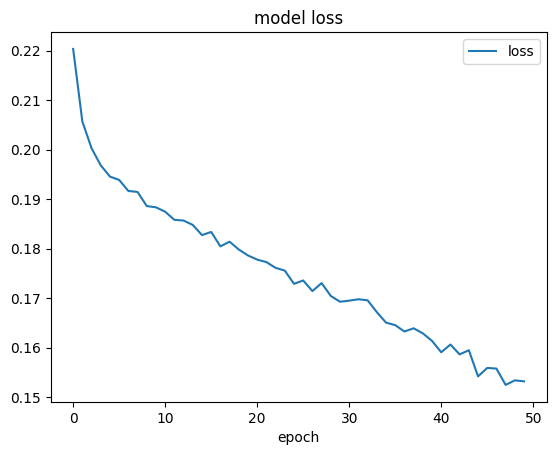

In [506]:
import matplotlib.pyplot as plt
# plt.plot(m.history['loss'])
plt.plot(m.history['mse'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','mse'], loc='upper right')
plt.show()

In [507]:
print("Inference:")
from keras.models import load_model
eval_act = load_model("weights_best.hdf5")

Inference:


In [508]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

289/289 [==============================] - 2s 3ms/step
AUC = 0.7391


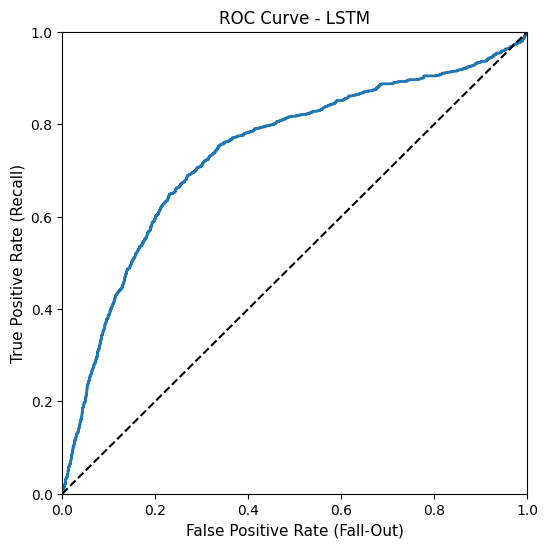

In [509]:
# Predict the test set using the best random forest regressor
y_pred = model.predict(test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
# fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(y_test, y_pred, pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

In [516]:
def print_results(M, X_train, Y_train, X_test, Y_test):
    # np.set_printoptions(suppress=True)
    # result1 = M.evaluate(X, Y, verbose = 2)
    # act_acc = np.round(result1[1]*100,2)
    # print("***[RESULT]*** ACT Accuracy: "+str(act_acc))
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)

    preds_train = M.predict(X_train)
    # preds_train = [1 if x > 0.5 else 0 for x in preds_train]
    preds_train = np.argmax(preds_train, axis=1)
    conf_mat_train = confusion_matrix(Y_train, preds_train)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    preds_test = M.predict(X_test)
    # preds_test = [1 if x > 0.5 else 0 for x in preds_test]
    preds_test = np.argmax(preds_test, axis=1)
    conf_mat_test = confusion_matrix(Y_test, preds_test)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    print("***[RESULT]*** ACT  Confusion Matrix")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(conf_mat_train, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(conf_mat_test, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
    
    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    # f1act = f1_score(np.argmax(Y_test, axis=1), preds_test, average=None).mean()
    f1act = f1_score(Y_test, preds_test)
    print("***[RESULT]*** Test F-1 Score : "+str(f1act*100))
    b_acc = balanced_accuracy_score(Y_test, preds_test)
    print("***[RESULT]*** Test Balanced Accuracy Score : "+str(b_acc*100))

289/289 [==============================] - 1s 3ms/step
***[RESULT]*** ACT  Confusion Matrix


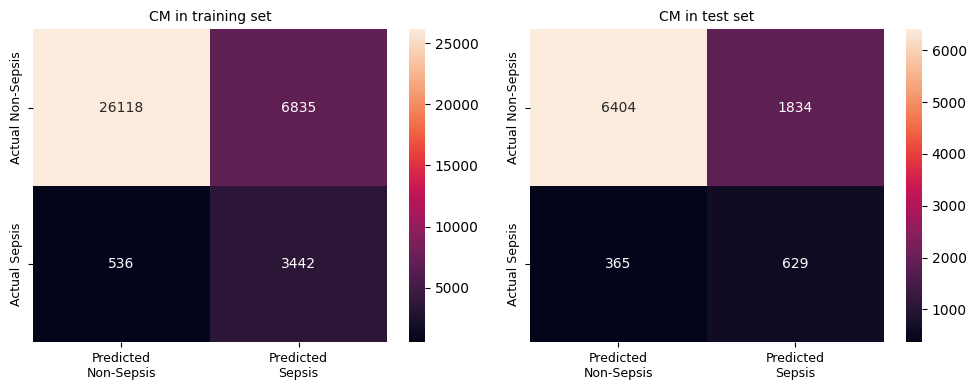

***[RESULT]*** Test F-1 Score : 36.38993346832514
***[RESULT]*** Test Balanced Accuracy Score : 70.50849647533171


In [517]:
print_results(model, train_data, y_train, test_data, y_test)

In [ ]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import tensorflow as tf
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

def LSTM_model():
    d = 0.25
    model=Sequential()
    model.add(Input(shape=(None, 32)))
    model.add(LSTM(128, return_sequences=True))
    # model.add(LSTM(4,return_sequences=True,input_shape=(32,4)))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(75))
    model.add(Dropout(d))
    model.add(Dense(25))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])

In [527]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import tensorflow as tf
from keras import regularizers
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

def LSTM_model():
    d = 0.25
    # lr = 0.01
    model=Sequential()
    model.add(Input(shape=(None, 32)))
    model.add(LSTM(128,return_sequences=True, activation='relu'))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(75, activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

model2 = LSTM_model()
model2.summary()
model2.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, None, 128)         82432     
                                                                 
 dropout_64 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_52 (LSTM)              (None, None, 64)          49408     
                                                                 
 dropout_65 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_53 (LSTM)              (None, 75)                42000     
                                                                 
 dropout_66 (Dropout)        (None, 75)                0         
                                                                 
 dense_32 (Dense)            (None, 25)              

In [535]:
print(tf.RaggedTensor.from_value_rowids(
    values=[3, 1, 4, 1, 5, 9, 2],
    value_rowids=[0, 0, 0, 0, 2, 2, 3]))

<tf.RaggedTensor [[3, 1, 4, 1], [], [5, 9], [2]]>


In [528]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_m2.hdf5', save_best_only = True, monitor='mse', mode='min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', patience = 20)
callbacks_list = [early_stop, checkpointer]
m2 = model2.fit(train_data, y_train, 
              class_weight=get_class_weights(),
              epochs=50, batch_size=64, verbose=1,
               callbacks=callbacks_list)

Epoch 1/50
578/578 [==============================] - 13s 17ms/step - loss: 0.4107 - mse: 0.1954
Epoch 2/50
  9/578 [..............................] - ETA: 8s - loss: 0.4642 - mse: 0.2164

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


578/578 [==============================] - 10s 17ms/step - loss: 0.3825 - mse: 0.1940
Epoch 3/50
578/578 [==============================] - 13s 22ms/step - loss: 0.3782 - mse: 0.1918
Epoch 4/50
578/578 [==============================] - 12s 20ms/step - loss: 0.3749 - mse: 0.1913
Epoch 5/50
578/578 [==============================] - 12s 20ms/step - loss: 0.3706 - mse: 0.1879
Epoch 6/50
578/578 [==============================] - 12s 21ms/step - loss: 0.3690 - mse: 0.1882
Epoch 7/50
578/578 [==============================] - 12s 20ms/step - loss: 0.3647 - mse: 0.1857
Epoch 8/50
578/578 [==============================] - 11s 20ms/step - loss: 0.3624 - mse: 0.1870
Epoch 9/50
578/578 [==============================] - 11s 20ms/step - loss: 0.3610 - mse: 0.1877
Epoch 10/50
578/578 [==============================] - 12s 20ms/step - loss: 0.3590 - mse: 0.1848
Epoch 11/50
578/578 [==============================] - 11s 20ms/step - loss: 0.3563 - mse: 0.1843
Epoch 12/50
578/578 [==================

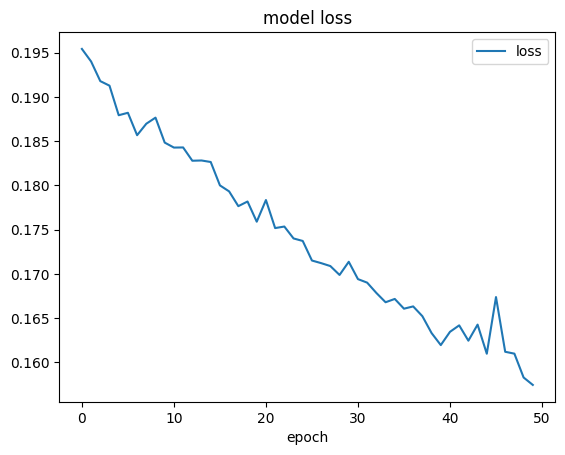

In [529]:
import matplotlib.pyplot as plt
# plt.plot(m.history['loss'])
plt.plot(m2.history['mse'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','mse'], loc='upper right')
plt.show()

In [522]:
print("Inference:")
from keras.models import load_model
model2 = load_model("weights_best_m2.hdf5")

Inference:


289/289 [==============================] - 1s 3ms/step
AUC = 0.7685


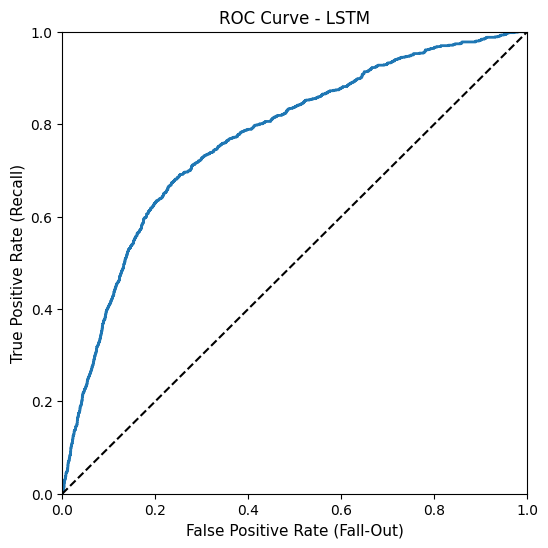

In [530]:
# Predict the test set using the best random forest regressor
y_pred = model2.predict(test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

289/289 [==============================] - 1s 3ms/step
***[RESULT]*** ACT  Confusion Matrix


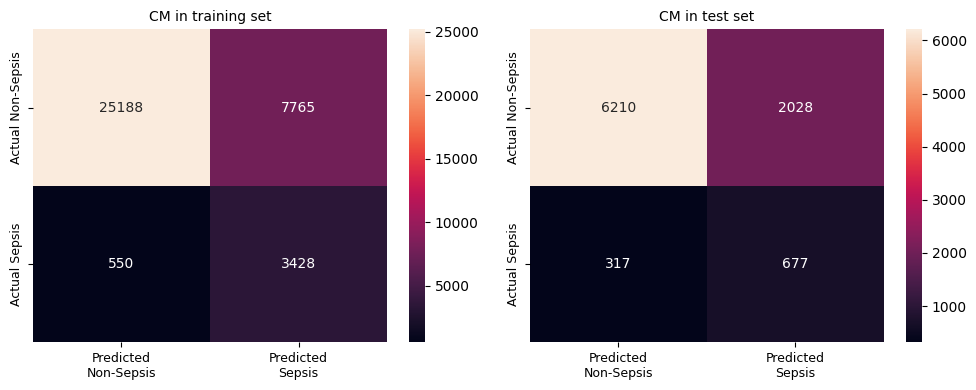

***[RESULT]*** Test F-1 Score : 36.60448769937821
***[RESULT]*** Test Balanced Accuracy Score : 71.7455131370891


In [531]:
print_results(model2, train_data, y_train, test_data, y_test)

289/289 [==============================] - 2s 5ms/step
AUC = 0.7613


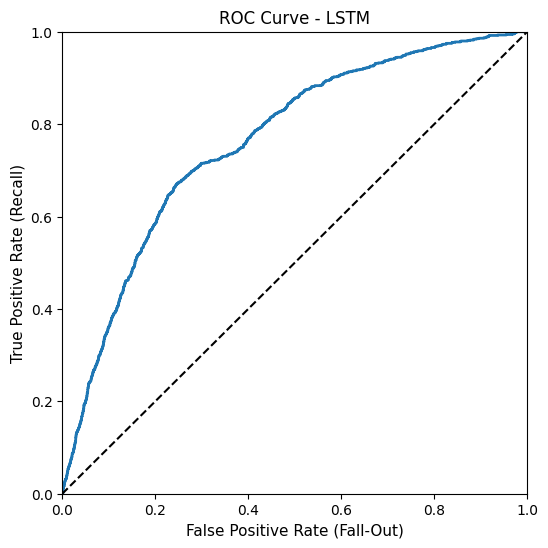

In [130]:
# Predict the test set using the best random forest regressor
y_pred = model2.predict(test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

289/289 [==============================] - 2s 8ms/step
***[RESULT]*** ACT  Confusion Matrix


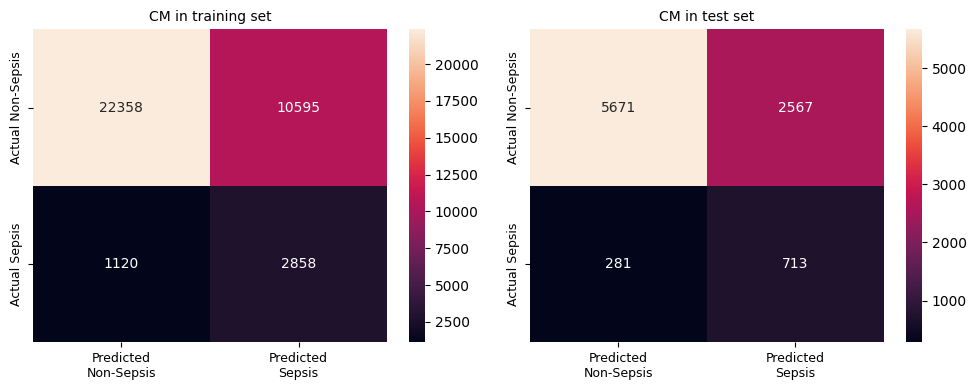

***[RESULT]*** Test F-1 Score : 33.36452971455311
***[RESULT]*** Test Balanced Accuracy Score : 70.2849532250556


In [131]:
print_results(model2, train_data, y_train, test_data, y_test)

In [94]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import tensorflow as tf
from keras import regularizers
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential
lr = 0.005
def LSTM_model():
    d = 0.25
    model=Sequential()
    model.add(LSTM(4,return_sequences=True,input_shape=(32,4), kernel_regularizer=regularizers.l2(lr), activation='relu'))
    model.add(Dropout(d))
    model.add(LSTM(4,return_sequences=True, kernel_regularizer=regularizers.l2(lr), activation='relu'))
    model.add(Dropout(d))
    model.add(LSTM(4, kernel_regularizer=regularizers.l2(lr), activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(25, kernel_regularizer=regularizers.l2(lr), activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(2, activation='relu'))

    return model

model3 = LSTM_model()
model3.summary()
model3.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 32, 4)             144       
                                                                 
 dropout_32 (Dropout)        (None, 32, 4)             0         
                                                                 
 lstm_25 (LSTM)              (None, 32, 4)             144       
                                                                 
 dropout_33 (Dropout)        (None, 32, 4)             0         
                                                                 
 lstm_26 (LSTM)              (None, 4)                 144       
                                                                 
 dropout_34 (Dropout)        (None, 4)                 0         
                                                                 
 dense_15 (Dense)            (None, 25)               

In [97]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_m3.hdf5', save_best_only = True, monitor='mse', mode='min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', patience = 20)
callbacks_list = [early_stop, checkpointer]
m3 = model3.fit(train_data, y_train, 
              class_weight=get_class_weights(),
              epochs=50, batch_size=128, verbose=1,
               callbacks=callbacks_list)

Epoch 1/50
289/289 [==============================] - 5s 19ms/step - loss: 0.5563 - mse: 0.2569
Epoch 2/50
  3/289 [..............................] - ETA: 11s - loss: 0.5344 - mse: 0.2612

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 5s 19ms/step - loss: 0.5261 - mse: 0.2456
Epoch 3/50
289/289 [==============================] - 6s 19ms/step - loss: 0.5137 - mse: 0.2421
Epoch 4/50
289/289 [==============================] - 5s 19ms/step - loss: 0.5052 - mse: 0.2390
Epoch 5/50
289/289 [==============================] - 5s 19ms/step - loss: 0.4973 - mse: 0.2355
Epoch 6/50
289/289 [==============================] - 6s 20ms/step - loss: 0.4902 - mse: 0.2338
Epoch 7/50
289/289 [==============================] - 6s 21ms/step - loss: 0.4872 - mse: 0.2316
Epoch 8/50
289/289 [==============================] - 6s 21ms/step - loss: 0.4824 - mse: 0.2321
Epoch 9/50
289/289 [==============================] - 6s 21ms/step - loss: 0.4797 - mse: 0.2313
Epoch 10/50
289/289 [==============================] - 6s 22ms/step - loss: 0.4761 - mse: 0.2302
Epoch 11/50
289/289 [==============================] - 6s 22ms/step - loss: 0.4716 - mse: 0.2309
Epoch 12/50
289/289 [============================

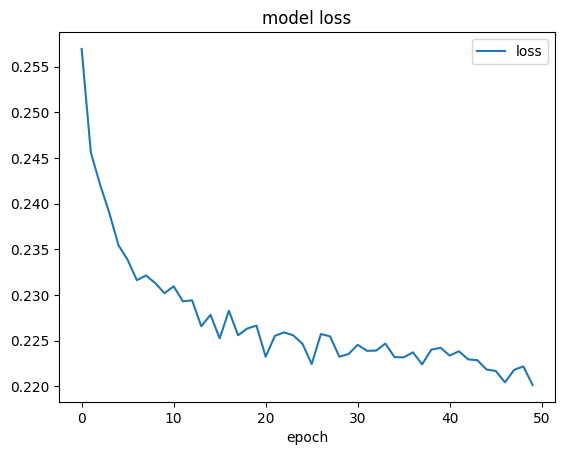

In [99]:
import matplotlib.pyplot as plt
# plt.plot(m.history['loss'])
plt.plot(m3.history['mse'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','mse'], loc='upper right')
plt.show()

289/289 [==============================] - 1s 4ms/step
AUC = 0.7232


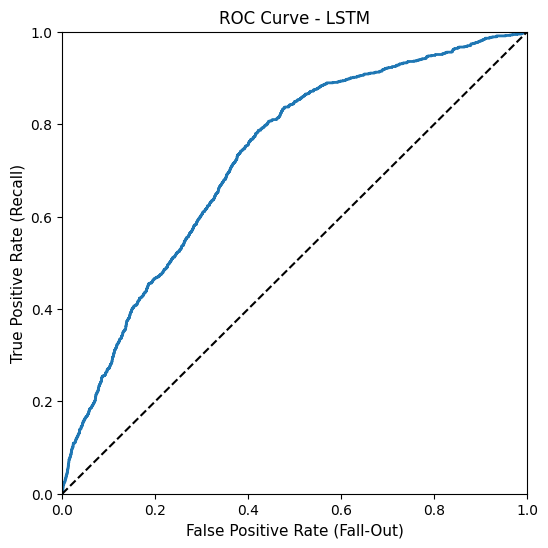

In [103]:
# Predict the test set using the best random forest regressor
y_pred = model3.predict(test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

289/289 [==============================] - 1s 4ms/step
***[RESULT]*** ACT  Confusion Matrix


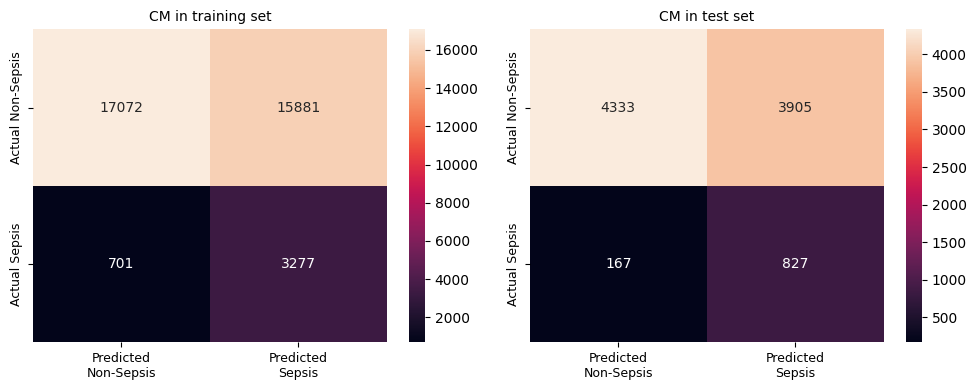

***[RESULT]*** Test F-1 Score : 28.88578414250786
***[RESULT]*** Test Balanced Accuracy Score : 67.89845653185928


In [102]:
print_results(model3, train_data, y_train, test_data, y_test)

In [119]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import tensorflow as tf
from keras import regularizers
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential
lr = 0.0015
def LSTM_model():
    d = 0.25
    model=Sequential()
    model.add(LSTM(4,return_sequences=True,input_shape=(32,4), kernel_regularizer=regularizers.l2(lr)))
    model.add(Dropout(d))
    model.add(LSTM(16,return_sequences=True, kernel_regularizer=regularizers.l2(lr)))
    model.add(Dropout(d))
    model.add(LSTM(75, kernel_regularizer=regularizers.l2(lr)))
    model.add(Dropout(d))
    model.add(Dense(25))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    return model

model4 = LSTM_model()
model4.summary()
model4.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 32, 4)             144       
                                                                 
 dropout_52 (Dropout)        (None, 32, 4)             0         
                                                                 
 lstm_40 (LSTM)              (None, 32, 16)            1344      
                                                                 
 dropout_53 (Dropout)        (None, 32, 16)            0         
                                                                 
 lstm_41 (LSTM)              (None, 75)                27600     
                                                                 
 dropout_54 (Dropout)        (None, 75)                0         
                                                                 
 dense_25 (Dense)            (None, 25)              

In [120]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_m4.hdf5', save_best_only = True, monitor='mse', mode='min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', patience = 20)
callbacks_list = [early_stop, checkpointer]
m4 = model4.fit(train_data, y_train, 
              class_weight=get_class_weights(),
              epochs=50, batch_size=128, verbose=1,
               callbacks=callbacks_list)

Epoch 1/50
289/289 [==============================] - 18s 47ms/step - loss: 0.5446 - mse: 0.2595
Epoch 2/50
  3/289 [..............................] - ETA: 12s - loss: 0.5275 - mse: 0.2256

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 13s 43ms/step - loss: 0.4912 - mse: 0.2381
Epoch 3/50
289/289 [==============================] - 13s 44ms/step - loss: 0.4789 - mse: 0.2359
Epoch 4/50
289/289 [==============================] - 14s 50ms/step - loss: 0.4670 - mse: 0.2299
Epoch 5/50
289/289 [==============================] - 14s 50ms/step - loss: 0.4633 - mse: 0.2288
Epoch 6/50
289/289 [==============================] - 15s 51ms/step - loss: 0.4532 - mse: 0.2263
Epoch 7/50
289/289 [==============================] - 16s 57ms/step - loss: 0.4509 - mse: 0.2271
Epoch 8/50
289/289 [==============================] - 24s 83ms/step - loss: 0.4457 - mse: 0.2227
Epoch 9/50
289/289 [==============================] - 22s 76ms/step - loss: 0.4448 - mse: 0.2220
Epoch 10/50
289/289 [==============================] - 29s 101ms/step - loss: 0.4399 - mse: 0.2209
Epoch 11/50
289/289 [==============================] - 29s 99ms/step - loss: 0.4368 - mse: 0.2190
Epoch 12/50
289/289 [=================

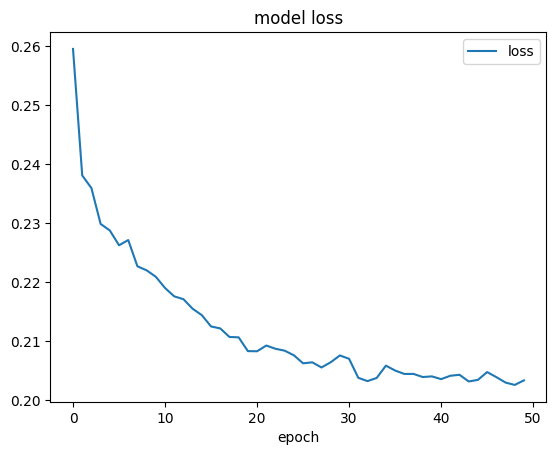

In [121]:
import matplotlib.pyplot as plt
# plt.plot(m.history['loss'])
plt.plot(m4.history['mse'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','mse'], loc='upper right')
plt.show()

In [122]:
print("Inference:")
from keras.models import load_model
model4 = load_model("weights_best_m4.hdf5")

Inference:


289/289 [==============================] - 3s 6ms/step
AUC = 0.7682


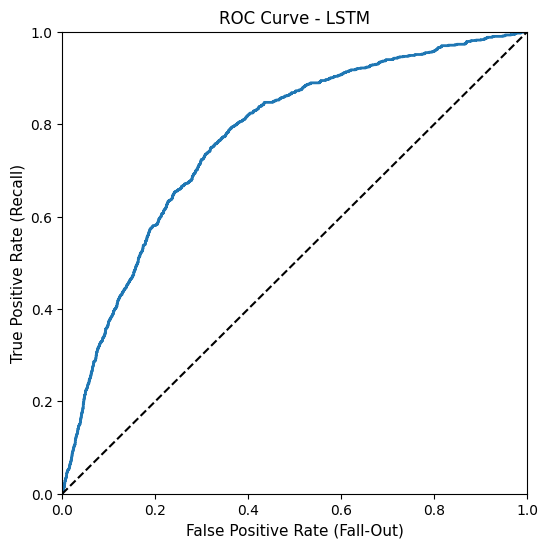

In [123]:
# Predict the test set using the best random forest regressor
y_pred = model4.predict(test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

289/289 [==============================] - 2s 6ms/step
***[RESULT]*** ACT  Confusion Matrix


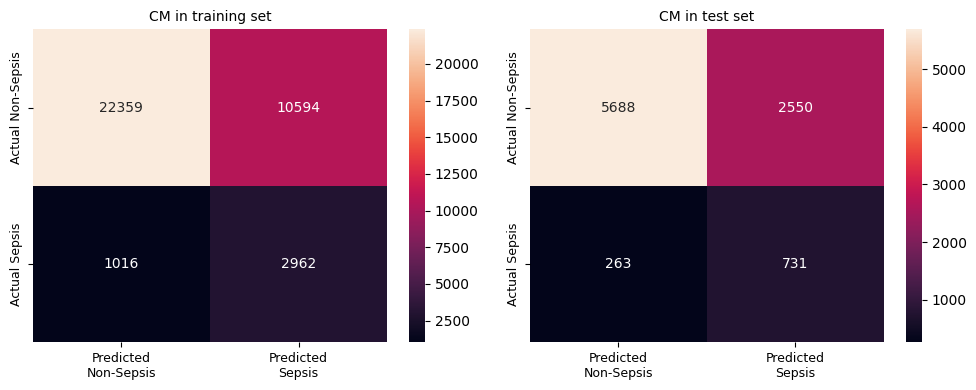

***[RESULT]*** Test F-1 Score : 34.198830409356724
***[RESULT]*** Test Balanced Accuracy Score : 71.2935662042173


In [124]:
print_results(model4, train_data, y_train, test_data, y_test)

# TimeSHAP

Model entry point

In [449]:
# f = lambda x: model.predict(new_train_data)
# f = lambda x: model.predict(new_train_data)[:,1]
f = lambda x: model.predict(train_data)
raw_model_features = train_t0_df.columns
model_features = [f"p_{x}_normalize" for x in np.delete(raw_model_features, [0,1,4])]

In [450]:
d_train_normalized = pd.DataFrame(X_t0_train, columns=np.delete(raw_model_features, [0,1,4]))
d_train_normalized = pd.concat([d_train_normalized, pd.DataFrame(X_t0_train, columns=model_features)], axis=1)
d_train_normalized = pd.concat([d_train_normalized, train_t0_df['HADM_ID']], axis=1)
d_train_normalized = pd.concat([d_train_normalized, pd.DataFrame(y_t0_train, columns=['IS_SEPSIS'])], axis=1)

d_test_normalized = pd.DataFrame(X_t0_test, columns=np.delete(raw_model_features, [0,1,4]))
d_test_normalized = pd.concat([d_test_normalized, pd.DataFrame(X_t0_test, columns=model_features)], axis=1)
d_test_normalized = pd.concat([d_test_normalized, test_t0_df['HADM_ID']], axis=1)
d_test_normalized = pd.concat([d_test_normalized, pd.DataFrame(y_t0_train, columns=['IS_SEPSIS'])], axis=1)

Baseline event

In [455]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(d_train_normalized, numerical_feats=model_features, categorical_feats=[])

In [456]:
average_event

,p_AGE_normalize,p_GENDER_NUM_normalize,p_ITEMID_50804_normalize,p_ITEMID_50813_normalize,p_ITEMID_50818_normalize,p_ITEMID_50820_normalize,p_ITEMID_50821_normalize,p_ITEMID_50862_normalize,p_ITEMID_50863_normalize,p_ITEMID_50878_normalize,...,p_ITEMID_51244_normalize,p_ITEMID_51248_normalize,p_ITEMID_51256_normalize,p_ITEMID_51265_normalize,p_ITEMID_51274_normalize,p_ITEMID_51275_normalize,p_ITEMID_51277_normalize,p_ITEMID_51279_normalize,p_ITEMID_51301_normalize,p_ITEMID_51493_normalize
0,0.166297,-0.877957,-0.698203,-0.891756,-0.698048,-0.734096,-0.691553,-0.631312,-0.788846,-0.615056,...,0.737016,0.369909,0.738636,0.264722,0.584432,0.602258,0.37024,0.370167,0.358418,-0.361592


In [76]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(d_train_normalized, numerical_feats=model_features, categorical_feats=[],model_features=model_features, entity_col='HADM_ID')

Average score over baseline

In [91]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best.hdf5")

Inference:


In [454]:
model.predict(test_data).shape

289/289 [==============================] - 1s 2ms/step


(9233, 1)

In [97]:
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=480)

1155/1155 [==============================] - 11s 10ms/step


## 3.1 Local Explanations

In [457]:
ids_for_test = np.random.choice(test_t0_df.HADM_ID.unique(), size = 4, replace=False)

positive_sequence_id = np.random.choice(ids_for_test)
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'] == positive_sequence_id]

# select model features only
pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = np.expand_dims(pos_x_data.to_numpy().copy(), axis=0)

### Select sequences to explain

In [458]:
from timeshap.explainer import local_report

plot_feats = {x:x for x in model_features}
pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 32000}
feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f, pos_x_data, pruning_dict, event_dict, feature_dict, cell_dict=cell_dict, entity_uuid=positive_sequence_id, entity_col='HADM_ID', baseline=average_event)

Assuming all features are model features
1155/1155 [==============================] - 3s 2ms/step


ValueError: cannot reshape array of size 36932 into shape (2,1)